# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to provide data analysis on the performed simulations.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# simulation output folder
# experiment_name = 'full_level_runs_1'
experiment_name = 'full_level_runs_4'

# load Java simulation data
# experiment_folder = fr'C:\Users\jesse\Documents\Java\TrafficSimulation-workspace\traffic-sim\src\main\resources\{experiment_name}'
experiment_folder = fr'C:\Users\jesse\Documents\EPA_TUDelft\MasterThesis\thesis_experiments\SIMLAB-BOTLEK\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [11]:
# load all available data for all seeds and runs
# combine the available data files with input values

# function to retrieve single data
def load_single_data(folder1, folder2, file, input_file):
    # create and save empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in folder2:
        # get all runs within this seed
        run_folders = get_file_names(os.path.join(folder1, seed_name))
        
        # get single data for all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            folder = os.path.join(folder1, seed_name, run_folder)
            data_path = os.path.join(folder, file)
            input_path = os.path.join(folder, input_file)
    
            # process run data
            df_run = pd.read_csv(data_path)
            df_run['run'] = run_number
            df_run.set_index('run', inplace=True)
    
            # add input data
            df_input = pd.read_csv(input_path)
            df_input['run'] = run_number
            df_input.set_index('run', inplace=True)
            df_run = pd.concat([df_run, df_input], axis=1)
    
            # add this data to the mean values DataFrame
            df = pd.concat([df, df_run])
    
    # sort DataFrame
    df.sort_index(inplace=True)

    # return DataFrame
    return df


# function to retrieve intermediate data
def load_intermediate_data(folder1, folder2, file, input_file):
    # create and save empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in folder2:
        # get all runs within this seed
        run_folders = get_file_names(os.path.join(folder1, seed_name))
        
        # get single data for all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            folder = os.path.join(folder1, seed_name, run_folder)
            data_path = os.path.join(folder, file)
            input_path = os.path.join(folder, input_file)
    
            # process run data
            df_run = pd.read_csv(data_path)
            df_run['run'] = run_number
    
            # process input data
            df_input = pd.read_csv(input_path)
    
            # broadcast input data to all rows in df_run
            for col in df_input.columns:
                df_run[col] = df_input[col].iloc[0]
    
            # add this data to the main DataFrame
            df = pd.concat([df, df_run])
    
    # sort DataFrame
    df.sort_index(inplace=True)
    df.index.name = 'time'
    df.reset_index(drop=False, inplace=True)
    df['time'] = df['time'] / 2

    # return DataFrame
    return df


# function to retrieve sequence data
def load_sequence_data(folder1, folder2, file, input_file):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in folder2:
        print(f'\n{seed_name}')
        
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder1, seed_name))
        
        # get acceleration data for all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            folder = os.path.join(folder1, seed_name, run_folder)
            data_path = os.path.join(folder, file)
            input_path = os.path.join(folder, input_file)
    
            # process run data
            df_run = pd.read_csv(data_path)
            df_run['run'] = run_number
    
            # # process input data
            df_input = pd.read_csv(input_path)
    
            # broadcast input data to all rows in df_run
            for col in df_input.columns:
                df_run[col] = df_input[col].iloc[0]
    
            # add this data to the main DataFrame
            df = pd.concat([df, df_run])
            print(f'Loaded data into DataFrame for: {run_folder}')

    # save data
    df.to_parquet('sequence_data_temp2.parquet', engine='pyarrow')

    # return sequence DataFrame
    return df
    

In [13]:
# get mean data
df_single = load_single_data(experiment_folder, seed_folders, single_output, input_values)

# get intermediate data
df_intermediate = load_intermediate_data(experiment_folder, seed_folders, intermediate_output, input_values)

# get sequence data
df_sequence = pd.read_parquet('sequence_data_temp2.parquet', engine='pyarrow')
# df_sequence = load_sequence_data(experiment_folder, seed_folders, sequence_output, input_values)

### 1. Vehicle behaviour of automation levels

### 2. Traffic performance

C:\Users\jesse\AppData\Local\Temp\ipykernel_87280\3248734484.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(df_x, df_y, degree)
C:\Users\jesse\AppData\Local\Temp\ipykernel_87280\3248734484.py:46: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(df_x, df_y, degree)


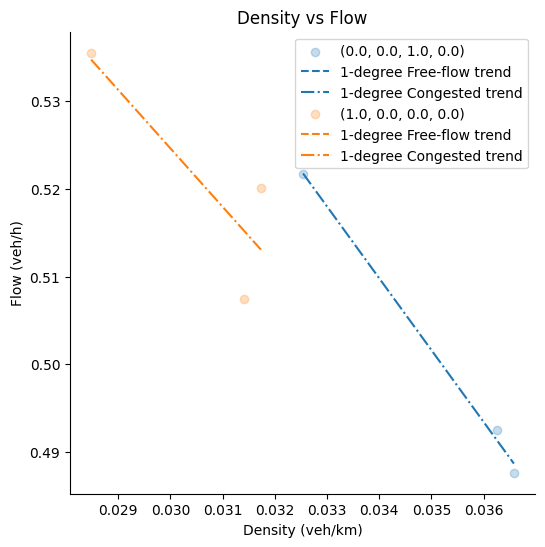

In [15]:
def show_fd_graph(df):
    # create figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])

    for name, group in grouped_df:
        df_group = grouped_df.get_group(name)
        df_group = df_group.reset_index()
        df_group = df_group.sort_values('mean_density')

        # split data for trend lines
        # mean_density_value = df_group['mean_density'].mean()
        max_flow_index = df_group['mean_flow'].idxmax()
        df_free_flow = df_group.loc[:max_flow_index]
        df_congested = df_group.loc[max_flow_index:]
        
        # df_free_flow = df_group[df_group['mean_density'] <= critical_density]
        # df_congested = df_group[df_group['mean_density'] > critical_density]
    
        # plot scatter group data
        scatter = ax.scatter(df_group['mean_density'], df_group['mean_flow'], label=name)
        color = scatter.get_facecolors()[0]
        color_t = color.copy()
        color_t[3] = 0.25
        scatter.set_facecolors(color_t)

        # add trend lines for first and second half of plot
        # add_trend_line(ax, df_x=df_group['mean_density'], df_y=df_group['mean_flow'], degree=2,
        #                line_type="-", line_color=color, name='Trend line')
        add_trend_line(ax, df_free_flow['mean_density'], df_free_flow['mean_flow'], degree=1, line_type='--', line_color=color, name='Free-flow trend')
        add_trend_line(ax, df_congested['mean_density'], df_congested['mean_flow'], degree=1, line_type='-.', line_color=color, name='Congested trend')

    # show plot
    ax.set_title('Density vs Flow')
    ax.set(xlabel='Density (veh/km)', ylabel='Flow (veh/h)')
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend()
    plt.show()


# function to add a trend line
def add_trend_line(ax, df_x, df_y, degree, line_type, line_color, name):
    # fit a polynomial trendline to data
    z = np.polyfit(df_x, df_y, degree)
    p = np.poly1d(z)
    # generate x and y values for the trend line
    x_fit = np.linspace(df_x.min(), df_x.max(), 100)
    y_fit = p(x_fit)
    # plot trend line
    ax.plot(x_fit, y_fit, line_type, color=line_color, label=f'{degree}-degree {name}')


show_fd_graph(df_single)

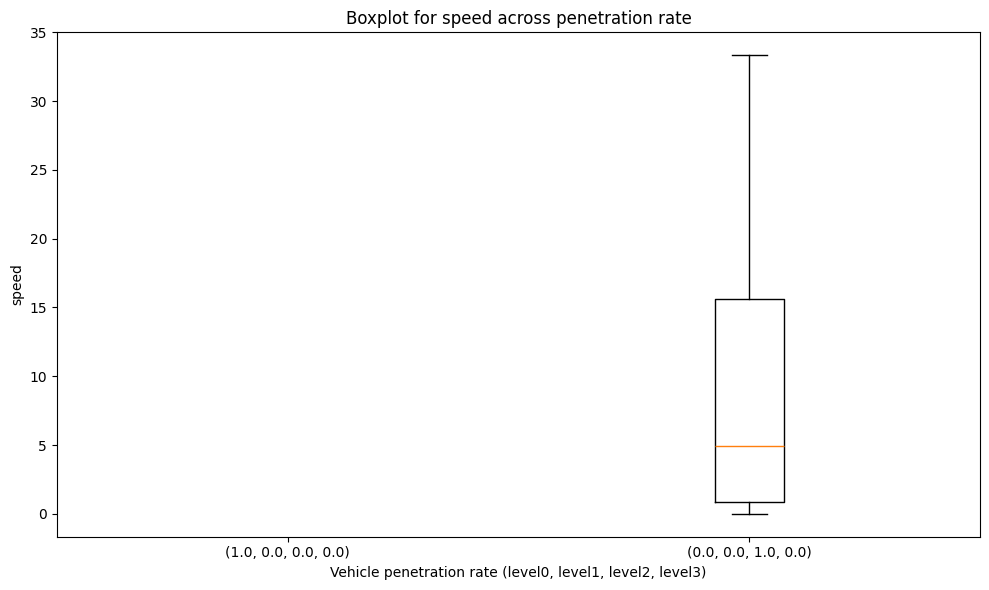

In [16]:
# function to compare mean values
def compare_speed_values(df):
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)
    
    # show boxplots for speed
    variables = ['speed',]
    for variable in variables:
        fig, ax = plt.subplots(figsize=(10, 6))
        box_data = []
        box_labels = []
    
        # loop through each group and collect data for the current variable
        for name in group_order:
            group = grouped_df.get_group(name)
            box_data.append(group[variable].values)
            box_labels.append(f'{name}')
        
        # create boxplot
        ax.boxplot(box_data, tick_labels=box_labels)
        ax.set_title(f'Boxplot for {variable} across penetration rate')
        ax.set_xlabel('Vehicle penetration rate (level0, level1, level2, level3)')
        ax.set_ylabel(variable)
            
        # display boxplot
        plt.tight_layout()
        plt.show()

# compare values
compare_speed_values(df_sequence)

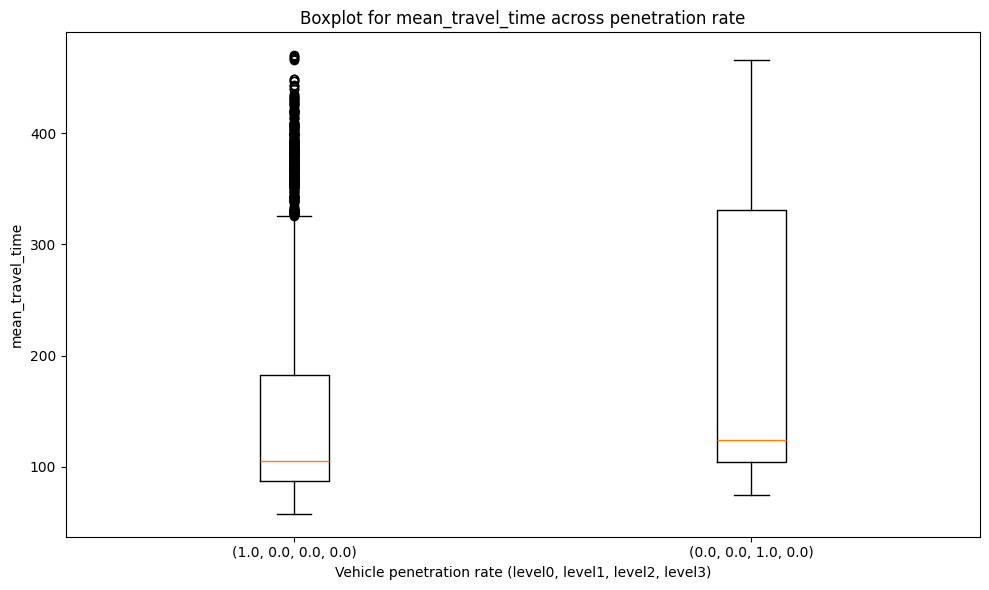

In [23]:
# function to compare mean values
def compare_travel_time_values(df):
    # we only need travel time, and this column has NaN values because there are less vehicles
    # in a simulation than time steps. Time steps and travel time is not linked
    df = df.dropna()
    
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)
    
    # show boxplots for speed
    variables = ['mean_travel_time',]
    for variable in variables:
        fig, ax = plt.subplots(figsize=(10, 6))
        box_data = []
        box_labels = []
    
        # loop through each group and collect data for the current variable
        for name in group_order:
            group = grouped_df.get_group(name)
            box_data.append(group[variable].values)
            box_labels.append(f'{name}')
        
        # create boxplot
        ax.boxplot(box_data, tick_labels=box_labels)
        ax.set_title(f'Boxplot for {variable} across penetration rate')
        ax.set_xlabel('Vehicle penetration rate (level0, level1, level2, level3)')
        ax.set_ylabel(variable)
            
        # display boxplot
        plt.tight_layout()
        plt.show()

# compare values
compare_travel_time_values(df_intermediate)

### 3. Traffic safety

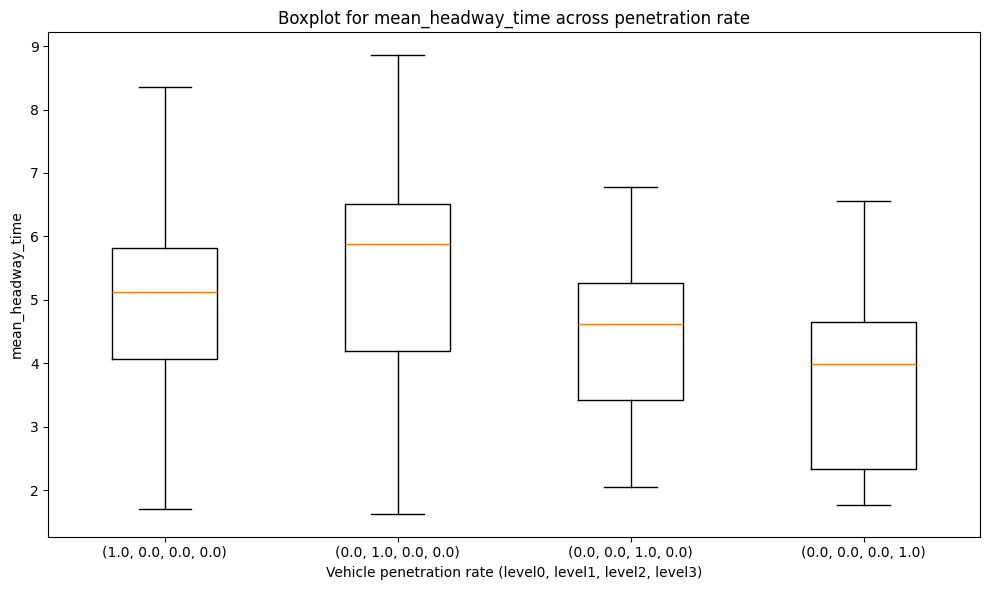

In [9]:
# function to compare mean values
def compare_mean_values(df):
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)
    
    # show boxplots for mean values
    # variables = ['mean_headway_time', 'mean_travel_time', 'mean_density', 'mean_flow', 'mean_speed']
    variables = ['mean_headway_time',]
    for variable in variables:
        fig, ax = plt.subplots(figsize=(10, 6))
        box_data = []
        box_labels = []
    
        # loop through each group and collect data for the current variable
        for name in group_order:
            group = grouped_df.get_group(name)
            box_data.append(group[variable].values)
            box_labels.append(f'{name}')
        
        # create boxplot
        ax.boxplot(box_data, tick_labels=box_labels)
        ax.set_title(f'Boxplot for {variable} across penetration rate')
        ax.set_xlabel('Vehicle penetration rate (level0, level1, level2, level3)')
        ax.set_ylabel(variable)
            
        # display boxplot
        plt.tight_layout()
        plt.show()

# compare values
compare_mean_values(df_single)

In [12]:
# function to filter acceleration data from sequence data DataFrame
def get_acceleration_data(df):
    # select required data
    variables = ['run', 'type', 'acceleration', 
                 'level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction']
    df_required = df[variables]

    # create acceleration and deceleration DataFrames
    # df_ready = df_required.astype({'acceleration' : "float"})
    df_required['acceleration'] = df_required['acceleration'].astype(float).copy()
    df_acceleration = df_required[df_required['acceleration'] > 0]
    df_deceleration = df_required[df_required['acceleration'] < 0]

    return df_acceleration, df_deceleration


# get acceleration data
df_acceleration, df_deceleration = get_acceleration_data(df_sequence)

C:\Users\jesse\AppData\Local\Temp\ipykernel_17012\1513080167.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_required['acceleration'] = df_required['acceleration'].astype(float).copy()


Acceleration:


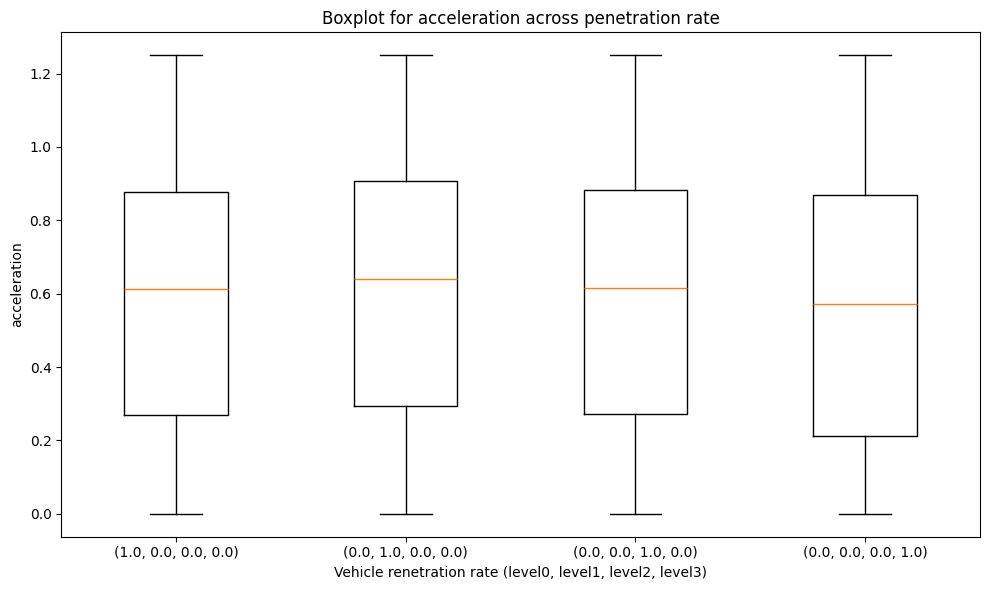


Deceleration:


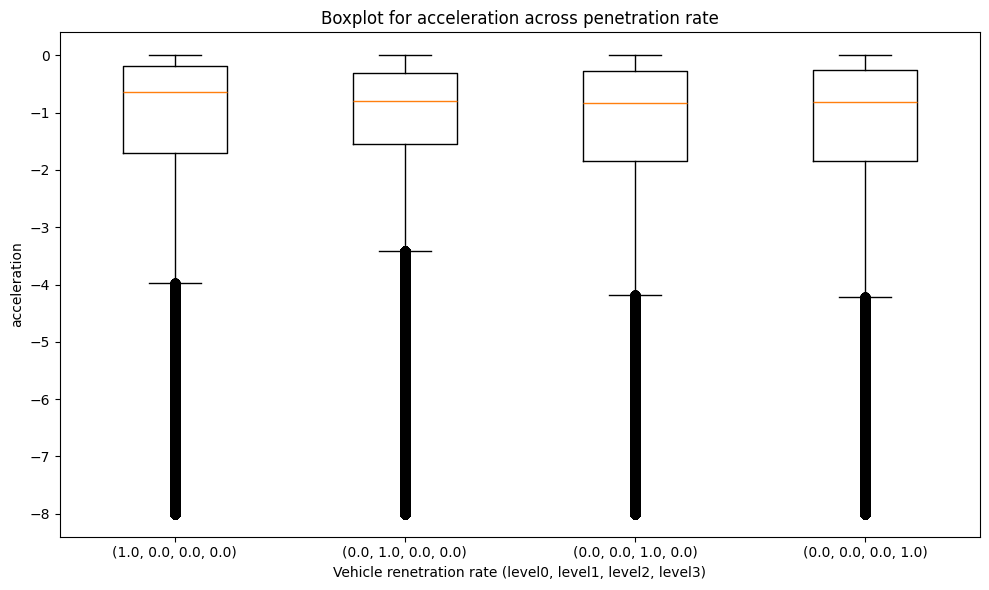

In [14]:
def compare_accelerations_for_penetration_rates(df):
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)
    
    # show boxplots
    fig, ax = plt.subplots(figsize=(10, 6))
    box_data = []
    box_labels = []
    
    # loop through each group and collect data for acceleration
    for name in group_order:
        group = grouped_df.get_group(name)
        box_data.append(group['acceleration'].values)
        box_labels.append(f'{name}')
        
    # create boxplot
    ax.boxplot(box_data, tick_labels=box_labels)
    ax.set_title(f'Boxplot for acceleration across penetration rates')
    ax.set_xlabel('Vehicle renetration rate (level0, level1, level2, level3)')
    ax.set_ylabel('acceleration')
        
    # display boxplot
    plt.tight_layout()
    plt.show()

print('Acceleration:')
compare_accelerations_for_penetration_rates(df_acceleration)
print('\nDeceleration:')
compare_accelerations_for_penetration_rates(df_deceleration)

In [25]:
data = {
    'level0_fraction': [0.374540, 0.950714, 0.731994, 0.598658, 0.156019, 0.155995, 0.058084, 0.866176, 0.601115, 0.708073],
    'level1_fraction': [0.031429, 0.636410, 0.314356, 0.508571, 0.907566, 0.249292, 0.410383, 0.755551, 0.228798, 0.076980],
    'level2_fraction': [0.642032, 0.084140, 0.161629, 0.898554, 0.606429, 0.009197, 0.101472, 0.663502, 0.005062, 0.160808],
    'level3_fraction': [0.051682, 0.531355, 0.540635, 0.637430, 0.726091, 0.975852, 0.516300, 0.322956, 0.795186, 0.270832],
    'time': ['2023-01-09', '2023-01-01', '2023-01-01', '2023-01-04', '2023-01-09', '2023-01-01', '2023-01-08', '2023-01-02', '2023-01-03', '2023-01-06'],
    'critical_ttc': [True, False, False, True, False, True, False, True, False, True]
}

df_test_ttc = pd.DataFrame(data)
print(df_test_ttc)

   level0_fraction  level1_fraction  level2_fraction  level3_fraction  \
0         0.374540         0.031429         0.642032         0.051682   
1         0.950714         0.636410         0.084140         0.531355   
2         0.731994         0.314356         0.161629         0.540635   
3         0.598658         0.508571         0.898554         0.637430   
4         0.156019         0.907566         0.606429         0.726091   
5         0.155995         0.249292         0.009197         0.975852   
6         0.058084         0.410383         0.101472         0.516300   
7         0.866176         0.755551         0.663502         0.322956   
8         0.601115         0.228798         0.005062         0.795186   
9         0.708073         0.076980         0.160808         0.270832   

         time  critical_ttc  
0  2023-01-09          True  
1  2023-01-01         False  
2  2023-01-01         False  
3  2023-01-04          True  
4  2023-01-09         False  
5  2023-01-01   

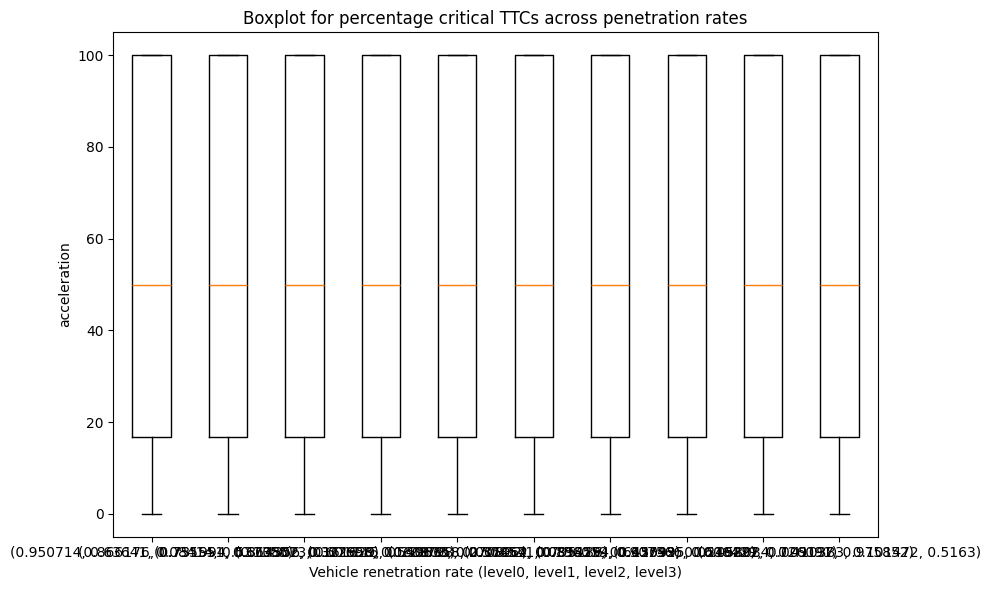

In [32]:
def percentage_critical_ttc(df):
    penetration_columns = ['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction']
    required_columns = ['time', 'critical_ttc']
    df_required = df[penetration_columns + required_columns]

    # groupby penetration rates
    grouped_df = df_required.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)

    # show boxplots
    fig, ax = plt.subplots(figsize=(10, 6))
    box_data = []
    box_labels = []
    
    # loop through each group and collect data for acceleration
    for name in group_order:
        group = grouped_df.get_group(name)
        # aggregate dataframe by time
        df_count_by_time = df_required.groupby('time').agg({'critical_ttc': ['sum', 'count'],}).reset_index()
        # flatten the multi-level columns
        df_count_by_time.columns = ['time', 'true_count', 'total_count']
        # calculate percentage
        df_percentage = df_count_by_time.copy()
        df_percentage['percentage_critical_ttc'] = df_percentage['true_count'] / df_percentage['total_count'] * 100

        # add to boxplot data
        box_data.append(df_percentage['percentage_critical_ttc'].values)
        box_labels.append(f'{name}')

    # create boxplot
    ax.boxplot(box_data, tick_labels=box_labels)
    ax.set_title(f'Boxplot for percentage critical TTCs across penetration rates')
    ax.set_xlabel('Vehicle renetration rate (level0, level1, level2, level3)')
    ax.set_ylabel('acceleration')
        
    # display boxplot
    plt.tight_layout()
    plt.show()

percentage_critical_ttc(df_test_ttc)